# Inverse Kinematics comparison

In [1]:
import sys
sys.path.append("../..")

from pathlib import Path
from pyosim import Analogs3dOsim
import pandas as pd
import numpy as np
import altair as alt
alt.data_transformers.enable("json")

DataTransformerRegistry.enable('json')

## Get the data

In [2]:
DATA_PATH = Path('./tests/IK_comparison')
PREFIX = 'wu_'

### Wide form

In [3]:
data = pd.DataFrame()
for ifile in DATA_PATH.glob("*.mot"):
    x = Analogs3dOsim().from_mot(ifile).time_normalization(np.linspace(0, 100, 100))
    solver = ifile.stem.split('_')[-1]
    f = ifile.stem.replace(PREFIX, "").replace(f'_{solver}', '')
    d = pd.DataFrame(x.squeeze().T, columns=x.get_2d_labels()).assign(
        filename=f,
        participant=f[:4],
        sex=f[4],
        height=f[-3],
        weight=f[5:].split("H")[0],
        trial=f[-1],
        solver=solver
    )
    data = pd.concat([data, d.reset_index()])

In [4]:
height = {
    '1': 'hips-shoulders',
    '2': 'hips-eyes',
    '3': 'shoulders-hips',
    '4': 'shoulders-eyes',
    '5': 'eyes-hips',
    '6': 'eyes-shoulders'
}
data['height'].replace(height, inplace=True)

In [5]:
data.head()

index  thorax_tilt  thorax_list  thorax_rotation  thorax_tx  thorax_ty  \
0      0    -4.753268    -0.968166        18.171718  -0.675251   0.528674   
1      1    -4.799849    -0.942509        18.273602  -0.675091   0.528382   
2      2    -4.709328    -0.977725        18.311173  -0.675462   0.528264   
3      3    -4.497326    -1.034325        18.196749  -0.676149   0.528236   
4      4    -4.226372    -1.012691        18.380433  -0.677140   0.528339   

   thorax_tz  sternoclavicular_r1  sternoclavicular_r2  sternoclavicular_r3  \
0   0.189542           -15.521010            -1.481583                  0.0   
1   0.189224           -15.759854            -1.480601                  0.0   
2   0.188703           -15.833448            -1.494009                  0.0   
3   0.188186           -15.784646            -1.570142                  0.0   
4   0.188307           -15.929740            -1.596305                  0.0   

    ...      pro_sup  hand_r_Add  hand_r_Flex     filename  participant  sex  \
0   ...   -58.317870   -7.475165   -20.379889  MarSF12H4_2         MarS    F   
1   ...   -58.701738   -7.032334   -20.412503  MarSF12H4_2         MarS    F   
2   ...   -58.890524   -7.183052   -20.402743  MarSF12H4_2         MarS    F   
3   ...   -58.763980   -6.874145   -20.222614  MarSF12H4_2         MarS    F   
4   ...   -58.599005   -7.126454   -20.119047  MarSF12H4_2         MarS    F   

           height  weight  trial  solver  
0  shoulders-eyes      12      2  kalman  
1  shoulders-eyes      12      2  kalman  
2  shoulders-eyes      12      2  kalman  
3  shoulders-eyes      12      2  kalman  
4  shoulders-eyes      12      2  kalman  

[5 rows x 27 columns]

### Long form

In [6]:
melted = data.melt(id_vars=['filename', 'participant', 'sex', 'height', 'weight', 'trial', 'index', 'solver'])
melted.head()

filename participant sex          height weight trial  index  solver  \
0  MarSF12H4_2        MarS   F  shoulders-eyes     12     2      0  kalman   
1  MarSF12H4_2        MarS   F  shoulders-eyes     12     2      1  kalman   
2  MarSF12H4_2        MarS   F  shoulders-eyes     12     2      2  kalman   
3  MarSF12H4_2        MarS   F  shoulders-eyes     12     2      3  kalman   
4  MarSF12H4_2        MarS   F  shoulders-eyes     12     2      4  kalman   

      variable     value  
0  thorax_tilt -4.753268  
1  thorax_tilt -4.799849  
2  thorax_tilt -4.709328  
3  thorax_tilt -4.497326  
4  thorax_tilt -4.226372

## Add features

In [7]:
melted['is_filtered'] = melted['solver'].apply(lambda x: x[-6:]) == 'filter'

In [8]:
melted['abs_diff'] = melted.groupby(['filename', 'variable'])['value'].diff().diff().abs()

In [9]:
scalar = melted.groupby(
    ["filename", "participant", "sex", "height", "weight", "solver", "is_filtered"]
)[["value", "abs_diff"]].agg(["mean", "sum", "std"])
scalar.columns = ["_".join(a) for a in scalar.columns.ravel()]
scalar.reset_index(inplace=True)
scalar.head()

filename participant sex          height weight         solver  \
0  MarSF12H4_2        MarS   F  shoulders-eyes     12         interp   
1  MarSF12H4_2        MarS   F  shoulders-eyes     12  interp-filter   
2  MarSF12H4_2        MarS   F  shoulders-eyes     12         kalman   
3  MarSF12H4_2        MarS   F  shoulders-eyes     12  kalman-filter   
4  MarSF12H4_2        MarS   F  shoulders-eyes     12             os   

   is_filtered  value_mean    value_sum  value_std  abs_diff_mean  \
0        False   -1.384476 -2630.503905  69.264116       2.198459   
1         True   -1.380570 -2623.083830  69.281701       2.193583   
2        False   -1.189370 -2259.802351  77.034845       1.789026   
3         True   -1.189039 -2259.174749  77.016314       1.771242   
4        False   -1.423565 -2704.773130  69.393552       2.195065   

   abs_diff_sum  abs_diff_std  
0   4177.072375     10.746900  
1   4167.808044     10.760299  
2   3331.166341      4.671612  
3   3365.360105      4.724162  
4   4170.623383      7.184573

In [10]:
scalar = scalar.join(
    scalar[
        [
            "value_mean",
            "value_sum",
            "value_std",
            "abs_diff_mean",
            "abs_diff_sum",
            "abs_diff_std",
        ]
    ]
    .apply(lambda x: np.sqrt((x - x.mean()) ** 2))
    .rename(columns=lambda x: f"dev_{x}")
)

## Visualization

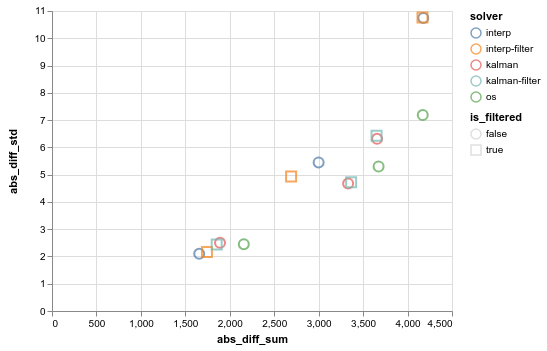

In [11]:
brush = alt.selection(type="interval", resolve="global")

base = (
    alt.Chart(scalar).encode(
        tooltip="filename",
        color=alt.condition(brush, "solver", alt.value("lightgray")),
        shape='is_filtered'
    )
).add_selection(brush)

chart_diff = base.mark_point(size=100).encode(x="abs_diff_sum", y="abs_diff_std")

chart_diff

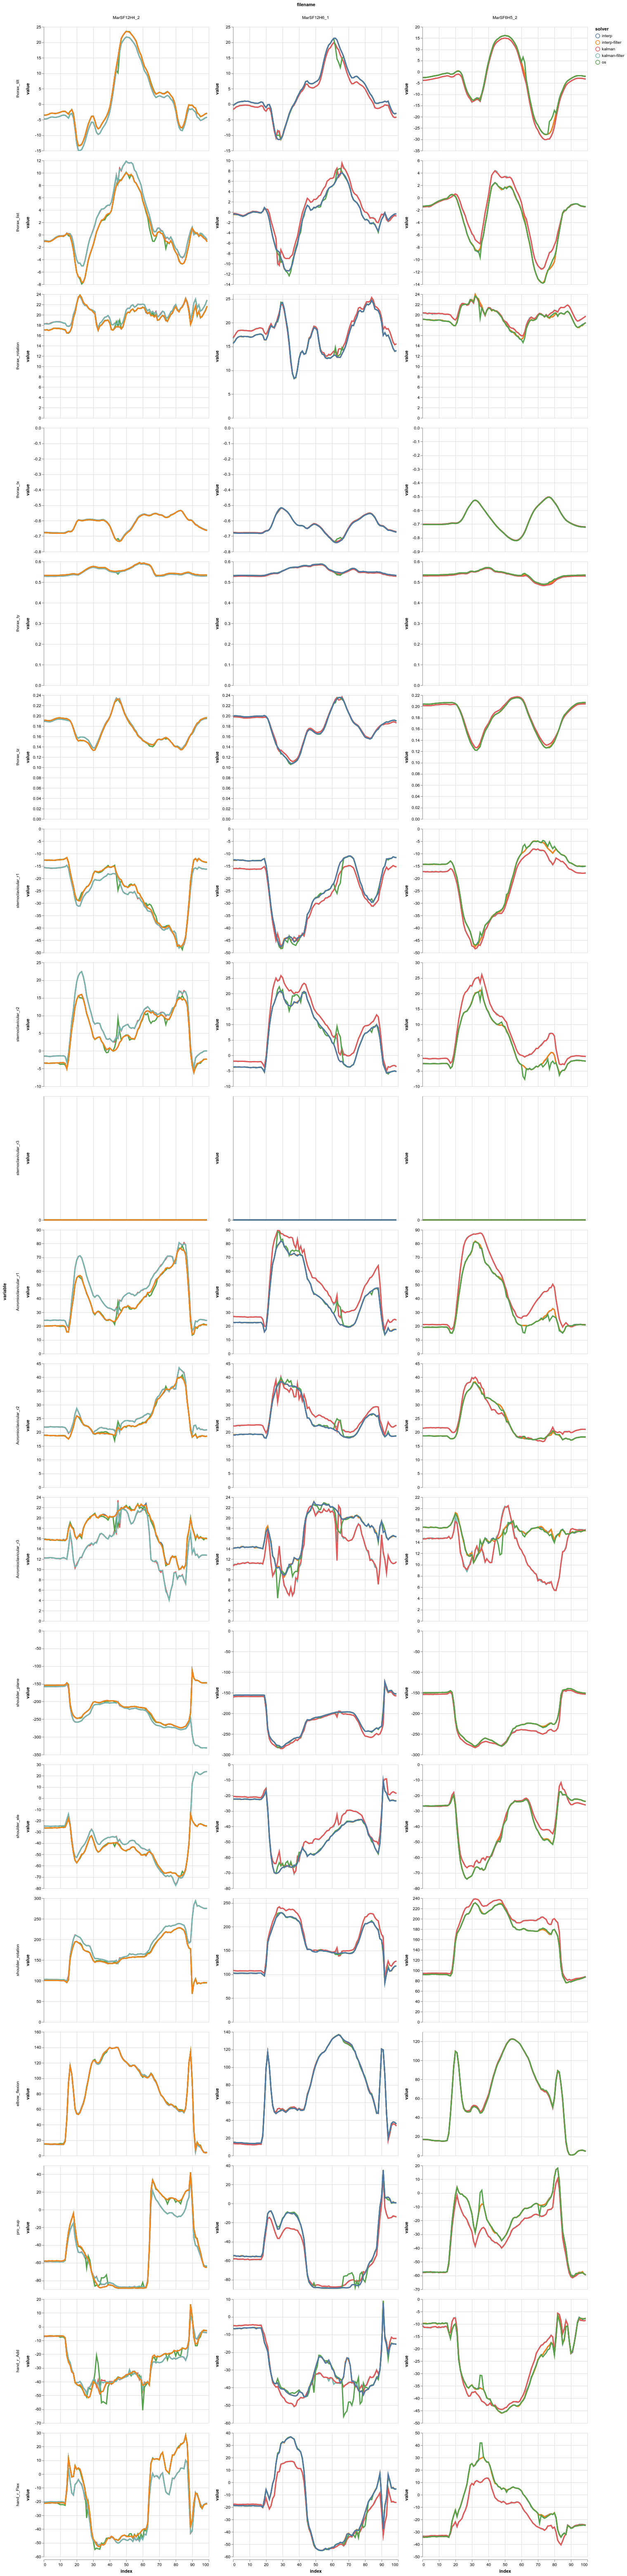

In [37]:
chart = (
    alt.Chart(melted)
    .mark_line(strokeWidth=3)
    .encode(x="index", y="value", detail=["filename", "solver"], color="solver", tooltip='filename')
    .facet(
        alt.Row("variable", sort=alt.Sort(x.get_2d_labels())), alt.Column("filename")
    )
).resolve_scale(y="independent")

chart

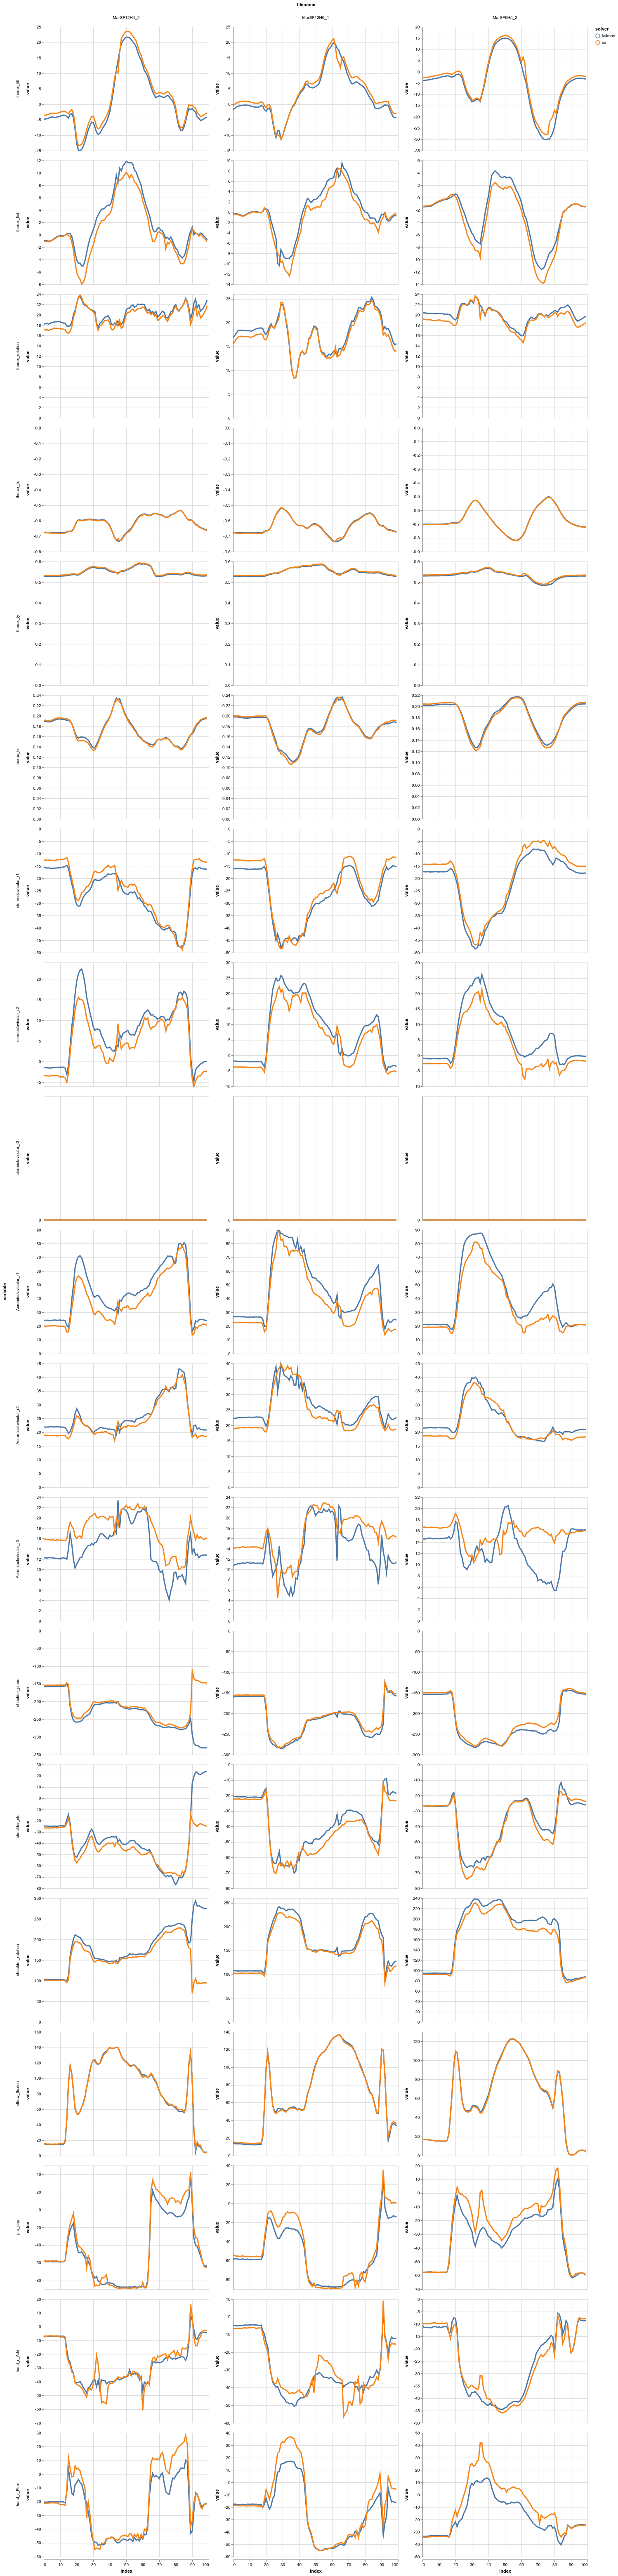

In [38]:
chart.transform_filter('datum.solver == "kalman" | datum.solver == "os"')

In [56]:
melted['solver'].replace('os', 'opensim', inplace=True)

In [57]:
melted['solver'].unique()

array(['kalman', 'interp', 'kalman-filter', 'interp-filter', 'opensim'],
      dtype=object)

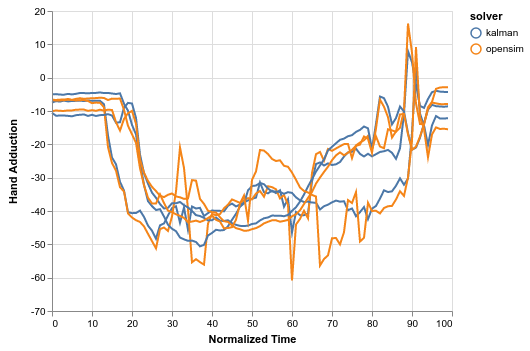

In [58]:
chart = (
    alt.Chart(melted)
    .mark_line()
    .encode(
        alt.X('index', title='Normalized Time'),
        alt.Y('value', title='Hand Adduction'),
        detail=["filename", "solver"],
        color="solver",
        tooltip="filename",
    )
).transform_filter(
    'datum.variable == "hand_r_Add" & (datum.solver == "kalman" | datum.solver == "opensim")'
)

chart